In [ ]:
 %pip install "qc-grader[qiskit,jupyter] @ git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git"

In [ ]:
%pip install pyscf

In [ ]:
%pip install ffsim

In [ ]:
%pip install qiskit_addon_sqd

In [1]:
import qiskit
import qc_grader
print(f"Qiskit version: {qiskit.__version__}")
print(f"Grader version: {qc_grader.__version__}")

Qiskit version: 2.1.1
Grader version: 0.22.12


In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(name="qgss-2025")
service.saved_accounts()

{'qgss-2025': {'channel': 'ibm_quantum_platform',
  'url': 'https://cloud.ibm.com',
  'token': 'TjsUi7FnctBL0cYkFsJAMNHrGJkb4Pj7Dn4Ct71RTUX9',
  'instance': 'crn:v1:bluemix:public:quantum-computing:us-east:a/0a47d07759a4490eb699bc3560c10e9b:7e0cbe99-6ea4-4ff0-889e-2db9b7a600e9::',
  'verify': True,
  'private_endpoint': False}}

In [3]:
import numpy as np
from math import comb
import warnings
import pyscf
import matplotlib.pyplot as plt
import pickle
from functools import partial

# Import qiskit classes
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_gate_map
from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch

# Import qiskit ecosystems
import ffsim
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit_ibm_runtime import SamplerOptions

# Import grader
from qc_grader.challenges.qgss_2025 import (
    grade_lab3_ex1, 
    grade_lab3_ex2, 
    grade_lab3_ex3,
    grade_lab3_ex4,
    grade_lab3_ex5
)

## Example: Calculate the size of the N2 Hamiltonian
 

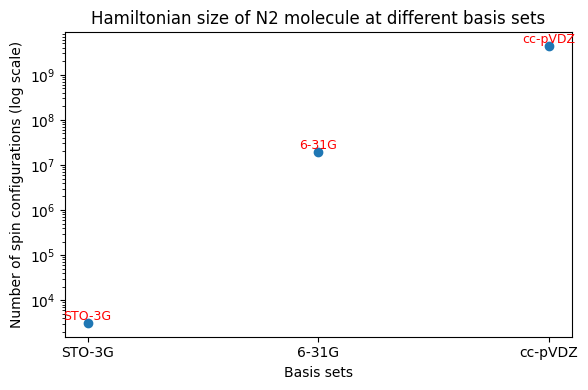

In [4]:
# Number of possible spin configurations
# Example: N2 molecule in STO-3G, 6-31G, and cc-pVDZ basis sets
# 14 electrons, 20 spin orbitals (from 10 spatial orbitals × 2)

# Calculate total electron configurations for each basis set
y1 = comb(8, 5) * comb(8, 5)       # STO-3G
y2 = comb(16, 5) * comb(16, 5)     # 6-31G
y3 = comb(26, 5) * comb(26, 5)     # cc-pVDZ

# Data
y = [y1, y2, y3]
x = list(range(len(y)))
labels = ['STO-3G', '6-31G', 'cc-pVDZ']

# Plot with logarithmic y-scale
plt.figure(figsize=(6, 4))
plt.plot(x, y, 'o')

plt.yscale('log')
plt.xticks(x, labels)
plt.xlabel('Basis sets')
plt.ylabel('Number of spin configurations (log scale)')
plt.title('Hamiltonian size of N2 molecule at different basis sets')

# Add labels above points
for i in range(len(x)):
    plt.text(x[i], y[i], f'{labels[i]}', fontsize=9, ha='center', va='bottom', color='red')

plt.tight_layout()
plt.show()

## Exercise 1: Measure the size of the O2 Hamiltonian

In [5]:
import math

# --- Exercise 1: Number of possible spin configurations
# --- Example: O2 molecule in 6-31G basis
# Based on the problem description (frozen core approximation):
# 16 spatial orbitals
# 7 alpha-spin electrons
# 5 beta-spin electrons

# Define the parameters for the calculation
num_spatial_orbitals = 16
num_alpha_electrons = 7
num_beta_electrons = 5

# --- TODO: Task 1 ---
### Provide your code below to calculate the total configurations

# Calculate the number of ways to arrange the alpha-spin electrons
# This is "16 choose 7"
a_config = math.comb(num_spatial_orbitals, num_alpha_electrons)

# Calculate the number of ways to arrange the beta-spin electrons
# This is "16 choose 5"
β_config = math.comb(num_spatial_orbitals, num_beta_electrons)

# The total number of configurations is the product of the two
total_config = a_config * β_config
# --- End of TODO ---

print(f"Total physical configurations for O2 in the given basis : {a_config} x {β_config} = {total_config}")

# --- Uncomment the line below for submission if required ---
# total_config = 49969920

Total physical configurations for O2 in the given basis : 11440 x 4368 = 49969920


In [6]:
grade_lab3_ex1(total_config)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### Exercise 2: Flip a bit by configuration recovery

In [7]:
# --- Setup from the first part of the exercise ---
# The initial bitstring and average orbital occupancy
x_full = np.array([1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0])
n_full = np.array([0.007, 0.029, 0.029, 0.995, 0.976, 0.976, 0.993, 0.997,
                   0.007, 0.029, 0.029, 0.995, 0.976, 0.976, 0.993, 0.997])

# Splitting data into beta (spin-down) and alpha (spin-up) parts
half_point = len(x_full) // 2
x_beta = x_full[:half_point]
x_alpha = x_full[half_point:]
n_beta = n_full[:half_point]

# Calculating the flip probability 'y_beta'
y_beta = np.abs(x_beta - n_beta)
# We only flip 0s to 1s, so set probability to 0 for occupied orbitals (1s)
y_beta[x_beta == 1] = 0.0
# --- End of setup ---


# --- Code for the provided screenshot ---

# Parameters for the weighted probability (ReLU) function
h = 5/8
delta = 0.01

# Initialize an array for the weighted probabilities
w = np.zeros(len(y_beta))

# --- TODO: Task 2 ---
# find the maximum w
for i in range(len(y_beta)):
    # Apply the modified ReLU function to each element of y_beta
    y_i = y_beta[i]
    if y_i <= h:
        w[i] = (delta * y_i) / h
    else:
        w[i] = delta + (1 - delta) * (y_i - h) / (1 - h)
# --- End of TODO ---

# Find the index that corresponds to the largest weighted probability
max_index = np.argmax(w)
max_w = w[max_index]

# print(f"Index to flip: {max_index}, with probability w={max_w:.4f}")


# Flip the bit of the index with the largest w
# --- TODO: Task 2 ---
# Make a copy of the original beta bitstring to modify
corrected_x_beta = x_beta.copy()

# Flip the bit at the most likely index (0 becomes 1)
corrected_x_beta[max_index] = 1

# The provided for-loop is not necessary to flip a single bit.
# The single line above is sufficient.

# Create the full corrected bitstring by joining the new beta part
# with the unchanged alpha part.
x = np.concatenate([corrected_x_beta, x_alpha])
corrected_x = x
# --- End of TODO ---

print(f"Original x:  {x_full}")
print(f"Corrected x: {corrected_x}")

Original x:  [1 0 0 0 1 0 1 1 1 0 1 1 1 1 0 0]
Corrected x: [1 0 0 1 1 0 1 1 1 0 1 1 1 1 0 0]


In [8]:
grade_lab3_ex2(corrected_x.tolist())

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


# Improve the ansatz

### Exercise 3: Change basis set

In [9]:
# Specify Molecule properties
open_shell = 0
spin_sq = 0

# Build N2 molecule
mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    # --- TODO: Task 3 ---
    basis = 'cc-pvdz',
    # --- End of TODO ---
    symmetry="Dooh",
)

# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())

# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# The print statement below will output 26
# print(num_orbitals)


# --- TODO: Task 3 ---
# 52 system qubits (2 * 26 orbitals) + 6 ancillary qubits
n_qubits = 58
# --- End of TODO ---

converged SCF energy = -108.929838385609


In [10]:
grade_lab3_ex3(n_qubits) 

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### Exercise 4: Select the best layout

In [11]:
 from qiskit_ibm_runtime import QiskitRuntimeService
 service = QiskitRuntimeService(name="qgss-2025")
 backend = service.backend('ibm_torino') 
 backend_target = backend.target

In [12]:
backend = service.backend('ibm_torino') 

In [13]:
import qiskit
print(f'Qiskit: {qiskit.__version__}')

Qiskit: 2.1.1


In [14]:
f = open('backend_target_v21.pkl', 'rb')
backend_target = pickle.load(f)
f.close()

In [28]:
BAD_READOUT_ERROR_THRESHOLD = 0.1  # Set threshold (adjust if instructed)

bad_readout_qubits = []

for q in range(backend_target.num_qubits):
    if (
        "measure" in backend_target
        and (q,) in backend_target["measure"]
        and backend_target["measure"][(q,)].error is not None
        and backend_target["measure"][(q,)].error > BAD_READOUT_ERROR_THRESHOLD
    ):
        bad_readout_qubits.append(q)

print("Bad readout qubits:", bad_readout_qubits)

# --- TODO: Task 4: Select initial layout for spin chains ---

# Spin A layout: Avoid bad readout and unconnected qubits
spin_a_layout = [
    0, 15, 19, 20, 21,
    34, 40, 41, 42, 54,
    61, 62, 63, 73,
    82, 83, 84, 93,
    103, 104, 105, 112,
    124, 123, 122, 121
]

# Spin B layout: Another disjoint chain of 26 qubits
spin_b_layout = [
    2, 3, 4, 16,
    23, 24, 25, 35,
    44, 45, 46, 55,
    65, 66, 67, 74,
    86, 87, 88, 94,
    107, 108, 109, 113,
    128, 127
]

initial_layout = spin_a_layout + spin_b_layout
print("Initial layout:", initial_layout)

# --- End of Tasks 3 and 4 ---


Bad readout qubits: [12, 53, 115, 126, 131]
Initial layout: [0, 15, 19, 20, 21, 34, 40, 41, 42, 54, 61, 62, 63, 73, 82, 83, 84, 93, 103, 104, 105, 112, 124, 123, 122, 121, 2, 3, 4, 16, 23, 24, 25, 35, 44, 45, 46, 55, 65, 66, 67, 74, 86, 87, 88, 94, 107, 108, 109, 113, 128, 127]


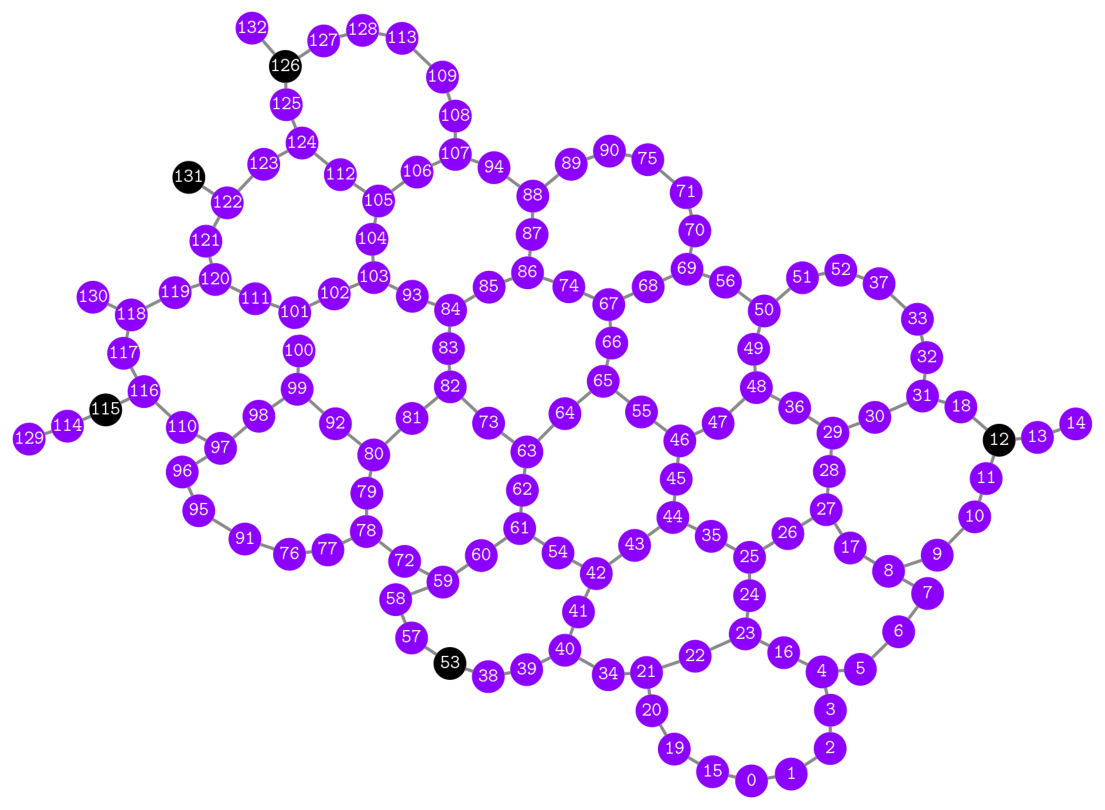

In [31]:
qubit_color = []
for i in range(backend_num_qubits):
    if i in bad_readout_qubits:
        qubit_color.append("#000000") #black
    else:
        qubit_color.append("#8c00ff") #purple
line_color = []
for e in backend_target.build_coupling_map().get_edges():
    if e in bad_czgate_edges:
        line_color.append("#ffffff") #white
    else:
        line_color.append("#888888") #gray
plot_gate_map(backend, qubit_color=qubit_color, line_color=line_color, qubit_size=50, font_size=25, figsize=(14,14))


In [32]:
# --- TODO: Task 4 ---

# Spin A layout: Chosen to avoid bad readout qubits and be within good CZ regions
spin_a_layout = [
    0, 15, 19, 20, 21,
    34, 40, 41, 42, 54,
    61, 62, 63, 73,
    82, 83, 84, 93,
    103, 104, 105, 112,
    124, 123, 122, 121
]

# Spin B layout: Another disjoint 26-qubit group with similar constraints
spin_b_layout = [
    2, 3, 4, 16,
    23, 24, 25, 35,
    44, 45, 46, 55,
    65, 66, 67, 74,
    86, 87, 88, 94,
    107, 108, 109, 113,
    128, 127
]

# Combine the two layouts
initial_layout = spin_a_layout + spin_b_layout

# --- End of TODO ---


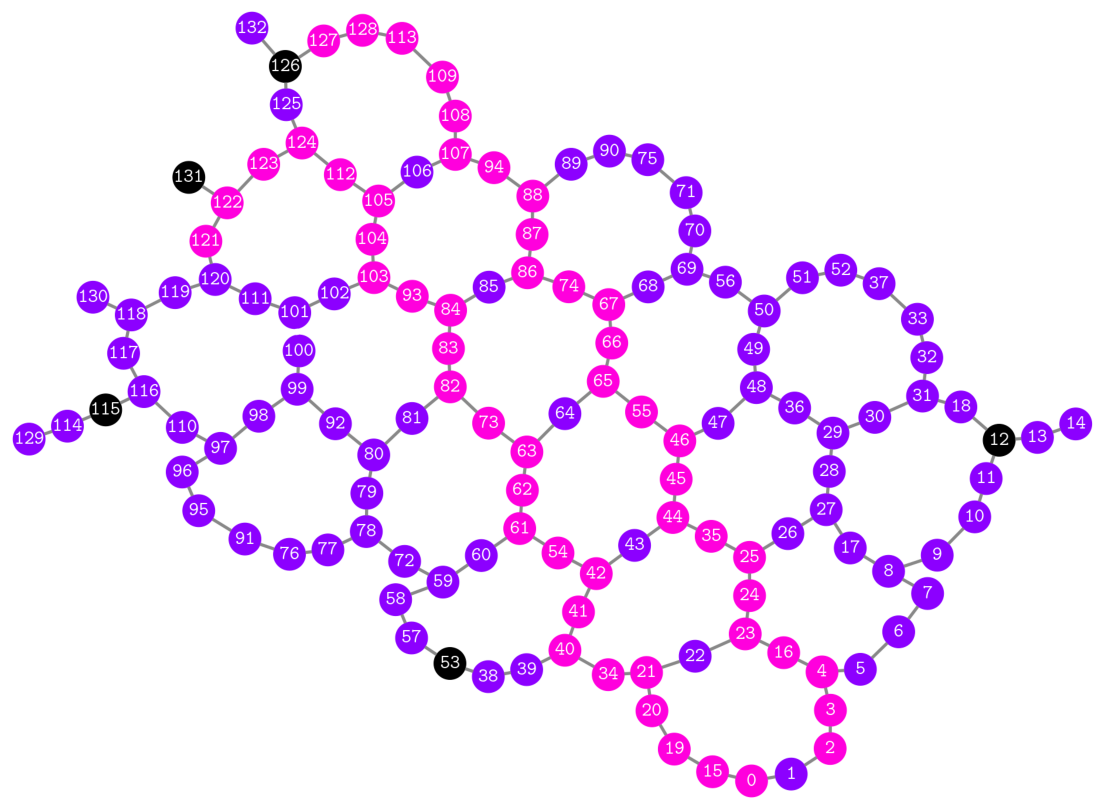

In [33]:
qubit_color = []
for i in range(backend_num_qubits):
    if i in bad_readout_qubits:
        qubit_color.append("#000000") #black
    elif i in initial_layout:
        qubit_color.append("#ff00dd") #pink
    else:
        qubit_color.append("#8c00ff") #purple
line_color = []
for e in backend_target.build_coupling_map().get_edges():
    if e in bad_czgate_edges:
        line_color.append("#ffffff") #white
    else:
        line_color.append("#888888") #gray
plot_gate_map(backend, qubit_color=qubit_color, line_color=line_color, qubit_size=50, font_size=25, figsize=(14,14))


In [34]:
grade_lab3_ex4(initial_layout)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### Exercise 5: Add more interaction to LUCJ ansatz

In [35]:
# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]).run()
t1 = ccsd.t1
t2 = ccsd.t2

n_reps = 1

# ---- TODO : Task 5 ---
# Include interactions between (p, p+1) and (p, p+2)
alpha_alpha_indices = [(p, p+1) for p in range(num_orbitals - 1)] + [(p, p+2) for p in range(num_orbitals - 2)]
# --- End of TODO ---

alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)

nelec = (num_elec_a, num_elec_b)

# create an empty quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)

# prepare Hartree-Fock state as the reference state and append it to the quantum circuit
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# apply the UCJ operator to the reference state
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()
circuit.decompose().decompose().draw("mpl", fold=-1)


E(CCSD) = -109.2177884185543  E_corr = -0.2879500329450036


In [36]:
grade_lab3_ex5(alpha_alpha_indices)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [37]:
from qc_grader.grader.grade import check_lab_completion_status

check_lab_completion_status("qgss_2025")

Lab 0: 2/2 exercises completed (100%)
    ✅ 2284 participants have completed this lab
Lab 1: 9/9 exercises completed (100%)
    ✅ 1752 participants have completed this lab
Lab 2: 7/7 exercises completed (100%)
    ✅ 1027 participants have completed this lab
Lab 3: 5/5 exercises completed (100%)
    ✅ 811 participants have completed this lab
Lab 4: 0/6 exercises completed (0%)
    ✅ 592 participants have completed this lab
Functions Labs: 0/8 exercises completed (0%)
    ✅ 4 participants have completed this lab
